In [27]:
#load model
from phi.flow import *
import numpy as np
from phi.field import curl
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from model import Transolver_Structured_Mesh_2D
import torch

model = Transolver_Structured_Mesh_2D.Model(space_dim=2,
                                  n_layers=8,
                                  n_hidden=64,
                                  dropout=0.0,
                                  n_head=8,
                                  Time_Input=False,
                                  fun_dim=20,
                                  out_dim=2,
                                  unified_pos=0,
                                  H=64, W=64).cuda()

#save_name = "ns_ep200_sim50_heads64"
save_name = "ns_unroll_ep400_sim50_t20"
#save_name = "buff_ns_unroll2_ep50_sim20_heads64"

model.load_state_dict(torch.load("./checkpoints/" + save_name + ".pt"), strict=False)
model.eval()

C:\Users\onurb\AppData\Local\Temp\ipykernel_26860\2680668194.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/" + save_na

Model(
  (preprocess): MLP(
    (linear_pre): Sequential(
      (0): Linear(in_features=22, out_features=128, bias=True)
      (1): GELU(approximate='none')
    )
    (linear_post): Linear(in_features=128, out_features=64, bias=True)
    (linears): ModuleList()
  )
  (blocks): ModuleList(
    (0-6): 7 x Transolver_block(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (Attn): Physics_Attention_Structured_Mesh_2D(
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.0, inplace=False)
        (in_project_x): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_fx): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (in_project_slice): Linear(in_features=8, out_features=32, bias=True)
        (to_q): Linear(in_features=8, out_features=8, bias=False)
        (to_k): Linear(in_features=8, out_features=8, bias=False)
        (to_v): Linear(in_features=8, out_features=8, bias=False)
        (to_out):

In [28]:
#get the simulation data
import phi.field


data_path = r"C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\data\\ns_200_20.npy"
data = np.load(data_path) #200, 64, 64, 40
test_data = data[-6, :, :, :40] # 64, 64, 40

#plot a simulation from the dataset
fields = np.transpose(test_data, (2,0,1)) # 40, 64, 64
sim = []
for i in range(20,40,2):
    velx = tensor(fields[i], spatial('x,y'))
    vely = tensor(fields[i+1], spatial('x,y'))

    f = StaggeredGrid(math.stack([velx, vely], dual(vector='x,y')), extrapolation.PERIODIC)
    sim.append(f)

v_trj = phi.field.stack(sim, batch('time'))

print(v_trj)
c_trj = curl(v_trj)
plot(c_trj, animate='time', frame_time=120, overlay='args')

Grid faces[(timeᵇ=10, ~vectorᵈ=x,y, xˢ=64, yˢ=64) 0.001 ± 0.375 (-1e+00...1e+00), ext=periodic]


torch.Size([1, 4096, 2])
0
tensor(1.3677, device='cuda:0', grad_fn=<SumBackward0>)
2
tensor(3.4292, device='cuda:0', grad_fn=<SumBackward0>)
4
tensor(10.2737, device='cuda:0', grad_fn=<SumBackward0>)
6
tensor(20.5787, device='cuda:0', grad_fn=<SumBackward0>)
8
tensor(32.7755, device='cuda:0', grad_fn=<SumBackward0>)
10
tensor(37.9530, device='cuda:0', grad_fn=<SumBackward0>)
12
tensor(32.3457, device='cuda:0', grad_fn=<SumBackward0>)
14
tensor(15.4940, device='cuda:0', grad_fn=<SumBackward0>)
16
tensor(4.2969, device='cuda:0', grad_fn=<SumBackward0>)
18
tensor(30.5515, device='cuda:0', grad_fn=<SumBackward0>)


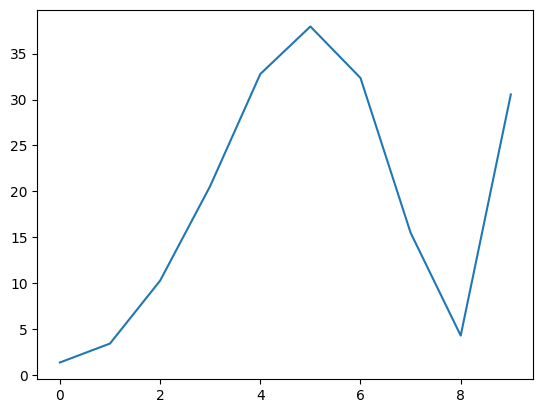

In [29]:
#define positional information
h = 64
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0).cuda()
print(pos.shape)

#predict next frames to get a simulation
test = test_data.reshape(1, -1, test_data.shape[-1]) #1, 4096, 40
test = torch.from_numpy(test)

yy = test[..., 20:40].cuda()
fx = test[...,:20].cuda()

sim_pred = []

step = 2

losses = []

for t in range(0,20,step):
    y = yy[..., t:t + step]
    pred = model(pos, fx=fx)
    print(t)

    loss = torch.sum(torch.pow(pred.reshape(1, -1) - y.reshape(1, -1),2))
    losses.append(loss.detach().item())
    print(loss)

    vx = pred[0,:,0]
    vy = pred[0,:,1]

    vx_field = vx.reshape(64,64)
    vy_field = vy.reshape(64,64)

    # Convert to PhiFlow tensors
    vx_field = tensor(vx_field, spatial('x,y'))
    vy_field = tensor(vy_field, spatial('x,y'))

    # Create a StaggeredGrid for the velocity field
    f = StaggeredGrid(math.stack([vx_field, vy_field], dual(vector='x,y')), extrapolation.PERIODIC)

    sim_pred.append(f)

    #update fx
    fx = torch.cat((fx[..., step:], pred), dim=-1)

v_trj_pred = phi.field.stack(sim_pred, batch('time'))

#print(v_trj_pred)
c_trj_pred = curl(v_trj_pred)
#plot(v_trj_pred, animate='time', frame_time=120, overlay='args')

import matplotlib.pyplot as plt

plt.plot(losses)

In [30]:
plot(c_trj_pred, animate='time', frame_time=120, overlay='args')